# Дообучение моделей выделения объектов

__Автор задач: Блохин Н.В. (NVBlokhin@fa.ru)__

Материалы:
* https://huggingface.co/docs/transformers/tasks/object_detection
* https://huggingface.co/docs/datasets/object_detection
* https://datasetninja.com/human-parts
* https://albumentations.ai/docs/getting_started/bounding_boxes_augmentation/#different-annotations-formats
* https://huggingface.co/docs/datasets/loading

In [32]:
# !pip install datasets transformers evaluate timm albumentations
# !pip install transformers[torch]

## Задачи для совместного разбора

1\. Обсудите процесс работы с архивами и Google Drive в Colab.

In [33]:
# !unzip './content/people.zip' -d './content/people_demo'

In [34]:
from pathlib import Path

In [35]:
dataset_root_path = './content/people'
dataset_root = Path(dataset_root_path)

In [36]:
list(dataset_root.iterdir())

[PosixPath('content/people/ann'), PosixPath('content/people/img')]

2\. Рассмотрите структуру датасета `cppe-5` и обсудите основные шаги по подготовке аналогичного датасета для дообучения модели.

In [37]:
from datasets import load_dataset

In [38]:
cppe_5 = load_dataset('cppe-5')

In [39]:
cppe_5['train'][0]

{'image_id': 15,
 'image': <PIL.Image.Image image mode=RGB size=943x663>,
 'width': 943,
 'height': 663,
 'objects': {'id': [114, 115, 116, 117],
  'area': [3796, 1596, 152768, 81002],
  'bbox': [[302.0, 109.0, 73.0, 52.0],
   [810.0, 100.0, 57.0, 28.0],
   [160.0, 31.0, 248.0, 616.0],
   [741.0, 68.0, 202.0, 401.0]],
  'category': [4, 4, 0, 0]}}

## Задачи для самостоятельного решения

1\. Создайте датасет `datasets.Dataset` на основе файлов из архива `people.zip`.

In [40]:
LABEL2ID = {
    'face': 0,
    'hand': 1,
    'person': 2,
}

CLASS_COLORS = [
    '#ba9109',
    '#7a1d90',
    '#493973'
]

ID2LABEL = {v: k for k, v in LABEL2ID.items()}

In [41]:
from dataclasses import dataclass, InitVar

In [42]:
@dataclass
class Box():
    xtl: InitVar[int]
    ytl: InitVar[int]
    xbr: InitVar[int]
    ybr: InitVar[int]
    label: str

    def __post_init__(self, xtl: int, ytl: int, xbr: int, ybr: int) -> None:
        self.x_min: float = float(xtl)
        self.y_min: float = float(ytl)
        self.width: float = float(xbr - self.x_min)
        self.height: float = float(ybr - self.y_min)
        self.area: float = self.width * self.height

    def get_bbox(self) -> list[float]:
        return [self.x_min, self.y_min, self.width, self.height]

In [43]:
box = Box(1, 2, 3, 4, 'myLabel')

In [44]:
box.x_min

1.0

In [45]:
import numpy as np
import json

import re

from PIL import Image

In [46]:
def create_annotation(file: Path, image_id: int, img_root: Path) -> dict:
    with open(file, 'r') as f:
        meta = json.load(f)
    
    img_file = img_root / Path(re.search(r'[^\\/]+.jpeg', str(file)).group(0))

    img = Image.open(img_file)

    annotation = {
        'image_id': image_id,
        'image': img,
        'width': meta['size']['width'],
        'height': meta['size']['height'],
        'objects': {
            'id': [],
            'area': [],
            'bbox': [],
            'category': [],
        }
    }

    for obj in meta['objects']:
        points = obj['points']['exterior']
        box = Box(*points[0], *points[1], obj['classTitle'])

        annotation['objects']['id'].append(obj['id'])
        annotation['objects']['area'].append(box.area)
        annotation['objects']['bbox'].append(box.get_bbox())
        annotation['objects']['category'].append(LABEL2ID[box.label])

    return annotation

In [47]:
dataset_root = Path('./content/people')
ann_folder = dataset_root / 'ann'
img_folder = dataset_root / 'img'

annotations_parsed = [
    create_annotation(file, idx, img_folder)
    for idx, file in enumerate(ann_folder.iterdir())
]

In [48]:
annotations_parsed[44]

{'image_id': 44,
 'image': <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=488x650>,
 'width': 488,
 'height': 650,
 'objects': {'id': [149077075,
   149077074,
   149077073,
   149077072,
   149077071,
   149077070,
   149077069,
   149077068],
  'area': [125715.0, 118680.0, 3105.0, 2944.0, 1170.0, 2088.0, 1330.0, 1056.0],
  'bbox': [[192.0, 80.0, 255.0, 493.0],
   [22.0, 100.0, 258.0, 460.0],
   [156.0, 123.0, 45.0, 69.0],
   [317.0, 108.0, 46.0, 64.0],
   [124.0, 332.0, 39.0, 30.0],
   [160.0, 331.0, 58.0, 36.0],
   [271.0, 340.0, 38.0, 35.0],
   [310.0, 338.0, 32.0, 33.0]],
  'category': [2, 2, 0, 0, 1, 1, 1, 1]}}

In [49]:
from datasets import Dataset

In [50]:
dataset = Dataset.from_list(annotations_parsed)

In [51]:
dataset

Dataset({
    features: ['image_id', 'image', 'width', 'height', 'objects'],
    num_rows: 205
})

2\. Воспользовавшись `PIL.ImageDraw`, визуализируйте bounding box для одного любого примера из датасета `dataset`. Раскрасьте рамки в цвет соответствующего класса, цвет названия класса сделайте черным.

In [52]:
from matplotlib import pyplot as plt
from PIL import ImageDraw, ImageFont

In [53]:
img_meta = annotations_parsed[44]
img_meta

{'image_id': 44,
 'image': <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=488x650>,
 'width': 488,
 'height': 650,
 'objects': {'id': [149077075,
   149077074,
   149077073,
   149077072,
   149077071,
   149077070,
   149077069,
   149077068],
  'area': [125715.0, 118680.0, 3105.0, 2944.0, 1170.0, 2088.0, 1330.0, 1056.0],
  'bbox': [[192.0, 80.0, 255.0, 493.0],
   [22.0, 100.0, 258.0, 460.0],
   [156.0, 123.0, 45.0, 69.0],
   [317.0, 108.0, 46.0, 64.0],
   [124.0, 332.0, 39.0, 30.0],
   [160.0, 331.0, 58.0, 36.0],
   [271.0, 340.0, 38.0, 35.0],
   [310.0, 338.0, 32.0, 33.0]],
  'category': [2, 2, 0, 0, 1, 1, 1, 1]}}

In [54]:
def bbox_visualize(img_meta):
    img = img_meta['image'].copy()
    draw = ImageDraw.Draw(img)

    for index in range(len(img_meta['objects']['id'])):
        objs = img_meta['objects']
        xywh = objs['bbox'][index]
        label = objs['category'][index]
        color = CLASS_COLORS[label]

        xyxy = [xywh[0], xywh[1], xywh[0] + xywh[2], xywh[1] + xywh[3]]

        draw.rectangle(xyxy, outline=color, width=3)
        draw.text([xyxy[0] + 8, xyxy[1]], text=ID2LABEL[label], fill='#000', stroke_fill='#fff', stroke_width=2, font_size=22)
        

    fig, ax = plt.subplots(figsize=(20, 16), ncols=2)
    for axi in ax:
        axi.set_xticks([])
        axi.set_yticks([])
    ax[0].imshow(img_meta['image'])
    ax[1].imshow(img)

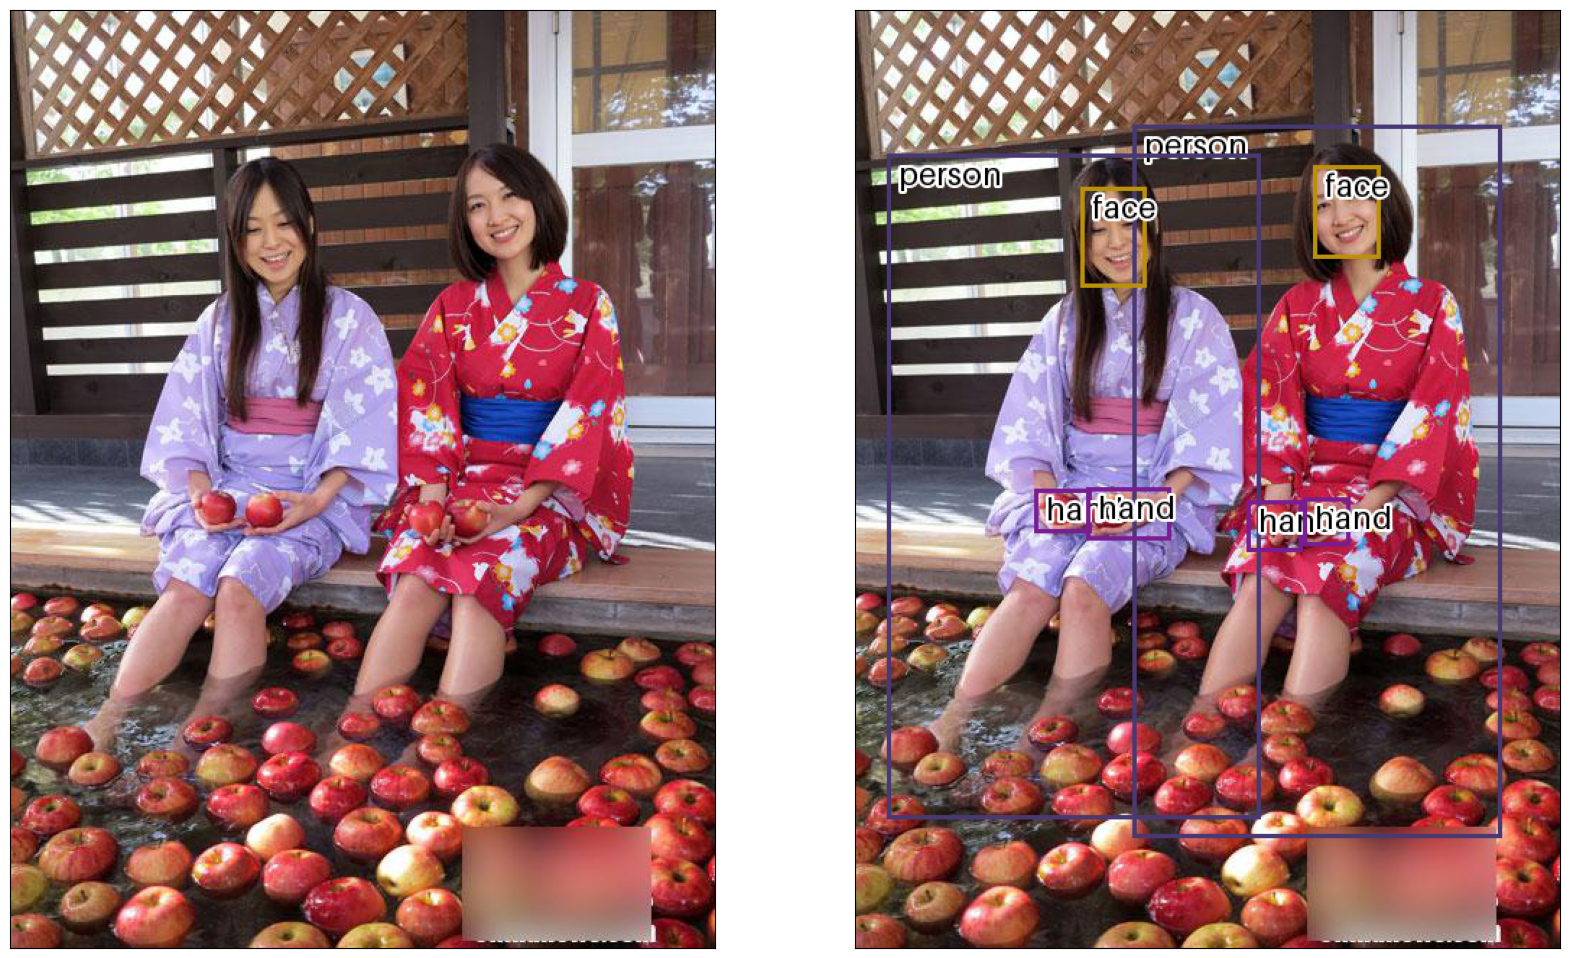

In [55]:
bbox_visualize(img_meta)

3\. Создайте преобразование `albumentations` для изменения размера изображения. Пропустите через это преобразование одно любое изображение из датасета с сохранением расположения bounding box и метки. Визуализируйте полученное уменьшенное изображение вместе с новыми bounding box и покажите, что преобразование отработало корректно.

In [56]:
import albumentations as A

In [57]:
transform = A.Compose([
    A.Resize(width=320, height=320, always_apply=True),
], bbox_params=A.BboxParams(format='coco', label_fields=['labels']))

In [58]:
transformed = transform(image=np.array(img_meta['image']), bboxes=img_meta['objects']['bbox'], labels=img_meta['objects']['category'])
transformed_image, transformed_bboxes = transformed['image'], transformed['bboxes']

In [59]:
img_meta_copy = img_meta.copy()
img_meta_copy['image'] = Image.fromarray(transformed_image)
img_meta_copy['objects']['bbox'] = transformed_bboxes

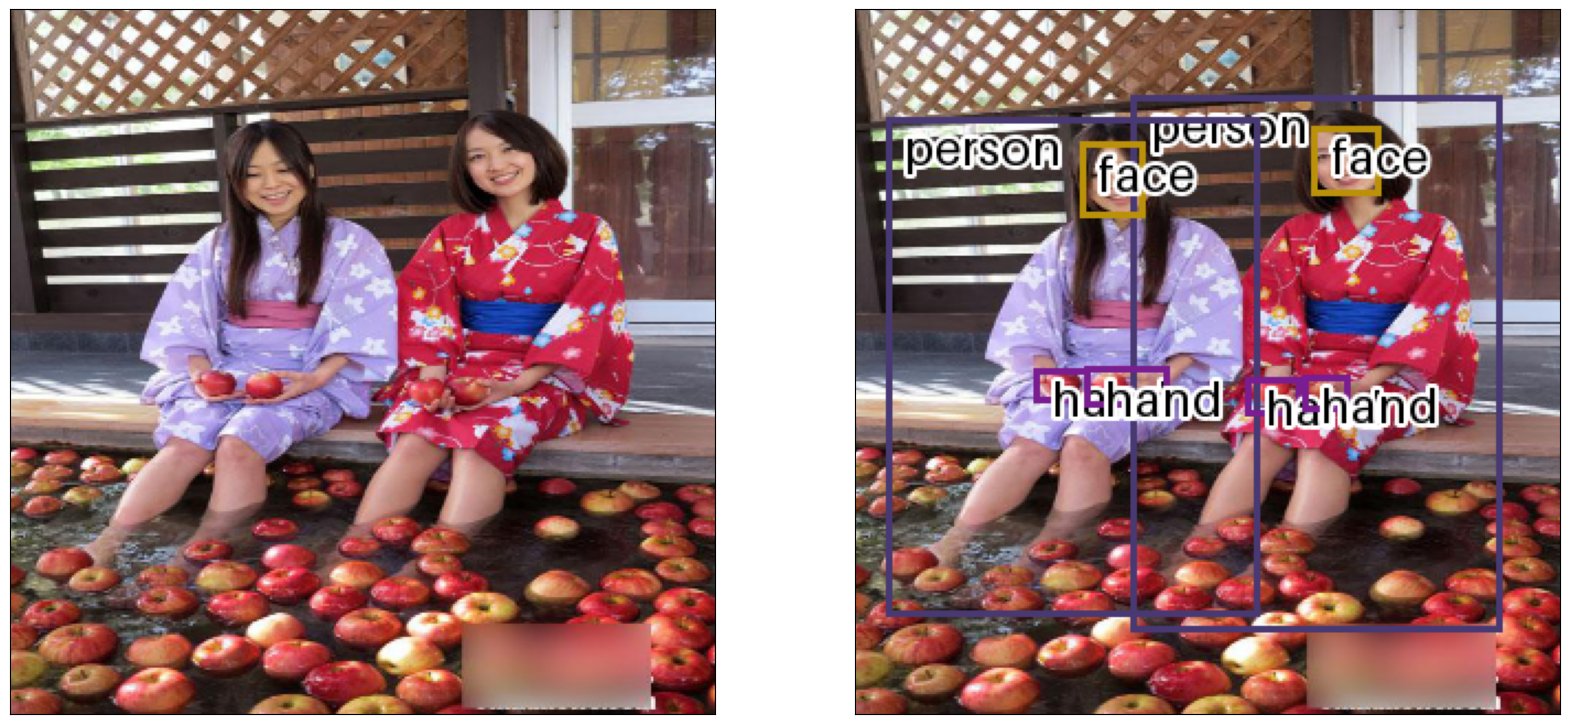

In [60]:
bbox_visualize(img_meta_copy)

4\. Используя `transformers.Trainer`, [дообучите](https://huggingface.co/docs/transformers/tasks/object_detection) модель `facebook/detr-resnet-50` для задачи выделения объектов трех классов: лица человека, руки человека и самого человека. При создании модели адаптируйте размерность выходного слоя и маппинг идентификаторов классов в соответствии с решаемой задачей.

Используя `pipeline` и выбрав подходящий `threshold`, сделайте прогноз для нескольких изображений из набора данных. Визуализируйте полученные прогнозы.

In [61]:
import torch

from transformers import (
    AutoModelForObjectDetection, AutoImageProcessor,
    TrainingArguments, Trainer,
)
from transformers.image_utils import load_image

import albumentations as A

In [62]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [63]:
if device.type == 'cuda':
    print(torch.cuda.get_device_name())

NVIDIA GeForce RTX 4090


In [64]:
model_id = 'facebook/detr-resnet-50'

In [65]:
dataset = dataset.train_test_split(0.1)
dataset

DatasetDict({
    train: Dataset({
        features: ['image_id', 'image', 'width', 'height', 'objects'],
        num_rows: 184
    })
    test: Dataset({
        features: ['image_id', 'image', 'width', 'height', 'objects'],
        num_rows: 21
    })
})

In [67]:
image_processor = AutoImageProcessor.from_pretrained(model_id)

In [68]:
transform = A.Compose(
    [
        A.Resize(480, 480),
        A.HorizontalFlip(p=1.0),
        A.RandomBrightnessContrast(p=1.0),
    ],
    bbox_params=A.BboxParams(format='coco', label_fields=['category']),
)

In [69]:
def formatted_anns(image_id, category, area, bbox):
    annotations = []
    for i in range(0, len(category)):
        new_ann = {
            'image_id': image_id,
            'category_id': category[i],
            'isCrowd': 0,
            'area': area[i],
            'bbox': list(bbox[i]),
        }
        annotations.append(new_ann)

    return annotations

In [70]:
def transform_aug_ann(examples):
    image_ids = examples['image_id']
    images, bboxes, area, categories = [], [], [], []
    for image, objects in zip(examples['image'], examples['objects']):
        image = np.array(image.convert('RGB'))[:, :, ::-1]
        out = transform(image=image, bboxes=objects['bbox'], category=objects['category'])

        area.append(objects['area'])
        images.append(out['image'])
        bboxes.append(out['bboxes'])
        categories.append(out['category'])

    targets = [
        {'image_id': id_, 'annotations': formatted_anns(id_, cat_, ar_, box_)}
        for id_, cat_, ar_, box_ in zip(image_ids, categories, area, bboxes)
    ]

    return image_processor(images=images, annotations=targets, return_tensors='pt')

In [71]:
dataset['train'] = dataset['train'].with_transform(transform_aug_ann)
dataset['test_transformed'] = dataset['test'].with_transform(transform_aug_ann)

In [72]:
def collate_fn(batch):
    pixel_values = [item['pixel_values'] for item in batch]
    encoding = image_processor.pad(pixel_values, return_tensors='pt')
    labels = [item['labels'] for item in batch]
    batch = {}
    batch['pixel_values'] = encoding['pixel_values']
    batch['pixel_mask'] = encoding['pixel_mask']
    batch['labels'] = labels
    return batch

In [73]:
model = AutoModelForObjectDetection.from_pretrained(
    model_id,
    num_labels=3,
    id2label=ID2LABEL,
    label2id=LABEL2ID,
    ignore_mismatched_sizes=True,
).to(device)

model.safetensors:  13%|#2        | 21.0M/167M [00:00<?, ?B/s]

INFO:timm.models._builder:Loading pretrained weights from Hugging Face hub (timm/resnet50.a1_in1k)


model.safetensors:   0%|          | 0.00/102M [00:00<?, ?B/s]

INFO:timm.models._hub:[timm/resnet50.a1_in1k] Safe alternative available for 'pytorch_model.bin' (as 'model.safetensors'). Loading weights using safetensors.
INFO:timm.models._builder:Missing keys (fc.weight, fc.bias) discovered while loading pretrained weights. This is expected if model is being adapted.
Some weights of the model checkpoint at facebook/detr-resnet-50 were not used when initializing DetrForObjectDetection: ['model.backbone.conv_encoder.model.layer1.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer2.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer3.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer4.0.downsample.1.num_batches_tracked']
- This IS expected if you are initializing DetrForObjectDetection from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT e

In [74]:
training_args = TrainingArguments(
    output_dir='detr-resnet-50_finetuned',
    evaluation_strategy='steps',
    eval_steps=100,
    num_train_epochs=50,
    fp16=True,
    remove_unused_columns=False,
)

In [76]:
trainer = Trainer(
    model=model,
    args=training_args,
    data_collator=collate_fn,
    train_dataset=dataset['train'],
    eval_dataset=dataset['test_transformed'],
    tokenizer=image_processor,
)

In [77]:
trainer.train()

  0%|          | 0/1150 [00:00<?, ?it/s]

The `max_size` parameter is deprecated and will be removed in v4.26. Please specify in `size['longest_edge'] instead`.


  0%|          | 0/3 [00:00<?, ?it/s]

{'eval_loss': 2.007589340209961, 'eval_runtime': 1.1359, 'eval_samples_per_second': 18.488, 'eval_steps_per_second': 2.641, 'epoch': 4.35}


  0%|          | 0/3 [00:00<?, ?it/s]

{'eval_loss': 1.6841974258422852, 'eval_runtime': 1.0769, 'eval_samples_per_second': 19.501, 'eval_steps_per_second': 2.786, 'epoch': 8.7}


  0%|          | 0/3 [00:00<?, ?it/s]

{'eval_loss': 1.3846909999847412, 'eval_runtime': 1.045, 'eval_samples_per_second': 20.096, 'eval_steps_per_second': 2.871, 'epoch': 13.04}


  0%|          | 0/3 [00:00<?, ?it/s]

{'eval_loss': 1.1567802429199219, 'eval_runtime': 1.0607, 'eval_samples_per_second': 19.799, 'eval_steps_per_second': 2.828, 'epoch': 17.39}
{'loss': 1.6722, 'learning_rate': 2.847826086956522e-05, 'epoch': 21.74}


  0%|          | 0/3 [00:00<?, ?it/s]

{'eval_loss': 1.1862999200820923, 'eval_runtime': 1.0752, 'eval_samples_per_second': 19.53, 'eval_steps_per_second': 2.79, 'epoch': 21.74}


  0%|          | 0/3 [00:00<?, ?it/s]

{'eval_loss': 1.179574728012085, 'eval_runtime': 1.0542, 'eval_samples_per_second': 19.921, 'eval_steps_per_second': 2.846, 'epoch': 26.09}


  0%|          | 0/3 [00:00<?, ?it/s]

{'eval_loss': 1.1746690273284912, 'eval_runtime': 1.0855, 'eval_samples_per_second': 19.347, 'eval_steps_per_second': 2.764, 'epoch': 30.43}


  0%|          | 0/3 [00:00<?, ?it/s]

{'eval_loss': 1.0447108745574951, 'eval_runtime': 1.0722, 'eval_samples_per_second': 19.586, 'eval_steps_per_second': 2.798, 'epoch': 34.78}


  0%|          | 0/3 [00:00<?, ?it/s]

{'eval_loss': 1.1300753355026245, 'eval_runtime': 1.0703, 'eval_samples_per_second': 19.621, 'eval_steps_per_second': 2.803, 'epoch': 39.13}
{'loss': 0.839, 'learning_rate': 6.782608695652175e-06, 'epoch': 43.48}


  0%|          | 0/3 [00:00<?, ?it/s]

{'eval_loss': 1.1977379322052002, 'eval_runtime': 1.0881, 'eval_samples_per_second': 19.3, 'eval_steps_per_second': 2.757, 'epoch': 43.48}


  0%|          | 0/3 [00:00<?, ?it/s]

{'eval_loss': 1.089221715927124, 'eval_runtime': 1.112, 'eval_samples_per_second': 18.885, 'eval_steps_per_second': 2.698, 'epoch': 47.83}
{'train_runtime': 577.5588, 'train_samples_per_second': 15.929, 'train_steps_per_second': 1.991, 'train_loss': 1.1802083554475205, 'epoch': 50.0}


TrainOutput(global_step=1150, training_loss=1.1802083554475205, metrics={'train_runtime': 577.5588, 'train_samples_per_second': 15.929, 'train_steps_per_second': 1.991, 'train_loss': 1.1802083554475205, 'epoch': 50.0})

In [78]:
model.save_pretrained('./detr-resnet-50_finetuned/checkpoint-final')

In [79]:
from transformers import ObjectDetectionPipeline

In [80]:
class CustomObjectDetectionPipeline(ObjectDetectionPipeline):
    def __init__(self, model, processor):
        super().__init__(model)

        self.model = model
        self.processor = processor

        self.id2label = self.model.config.id2label
        self.label2id = self.model.config.label2id

    def predict(self, images):
        transform = A.Compose([
            A.Resize(width=480, height=480, always_apply=True),
        ])

        images_tr = [transform(image=np.array(image))['image'] for image in images]

        results = []
        for image in images:
            inputs = image_processor(images=image, return_tensors="pt")
            inputs = {k: v.to(model.device) for k, v in inputs.items()}

            with torch.no_grad():
                outputs = model(**inputs)

            target_sizes = torch.tensor([[transform[0].width, transform[0].height][::-1]])
            result = image_processor.post_process_object_detection(
                outputs,
                target_sizes=target_sizes,
                threshold=0.65,
            )[0]

            results.append(result)
        
        return images_tr, results
    
    def __call__(self, *args, **kwargs):
        return self.predict(*args, **kwargs)

In [81]:
my_pipeline = CustomObjectDetectionPipeline(model=model, processor=image_processor)
predictions = my_pipeline(dataset['test'][4:6]['image'])

In [82]:
images, results = predictions

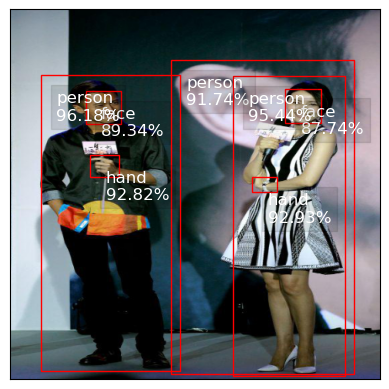

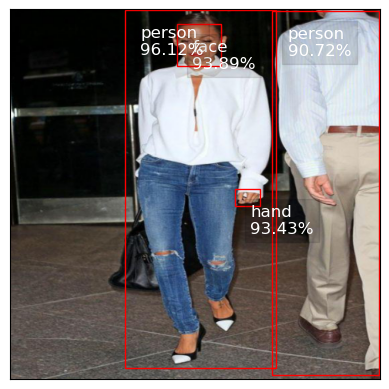

In [85]:
for ix in range(len(images)):
    fig, ax = plt.subplots()

    ax.imshow(images[ix])

    for score, label, box in zip(results[ix]['scores'], results[ix]['labels'], results[ix]['boxes']):
        box = box.tolist()
        ax.add_patch(plt.Rectangle((box[0], box[1]), box[2]-box[0], box[3]-box[1], color='red', fill=None))
        ax.text(
            box[0]+20, box[1]+20, f'{model.config.id2label[label.item()]}\n{score.item()*100:.2f}%',
            color='white', bbox={'facecolor': 'black', 'alpha': 0.1}, fontsize=12,
            verticalalignment='top',
        )
        ax.set_xticks([])
        ax.set_yticks([])

    plt.show()

5\. Для каждого человека определите, какие части тела были обнаружены моделью. Для решения этой задачи исследуйте пересечения полученных bounding box.

In [86]:
...

Ellipsis

6\. Дообучите подходящую модель на наборе данных, собранных вами на предыдущей неделе. Продемонстрируйте результат.

In [51]:
...

Ellipsis